In [1]:
import time
import random
import numpy as np
import pandas as pd
import networkx as nx
from scipy.io import mmread
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
from collections import defaultdict

In [2]:
matrix = mmread("econ-orani678.mtx").tocoo()

G = nx.from_scipy_sparse_array(matrix)

In [3]:
def print_network_summary(graph):
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    num_self_loops = nx.number_of_selfloops(graph)
    degrees = [deg for _, deg in graph.degree()]

    edge_weights = []
    for _, _, data in graph.edges(data=True):
        w = data.get("weight", 1.0)
        if w is not None:
            edge_weights.append(w)

    is_directed = nx.is_directed(graph)
    is_weighted = any("weight" in data for _, _, data in graph.edges(data=True))

    print("Number of nodes:", num_nodes)
    print("Number of edges (total):", num_edges)
    print("Number of self-loops:", num_self_loops)
    print("Number of edges (excluding self-loops):", num_edges - num_self_loops)
    print("Average degree:", sum(degrees) / len(degrees))
    print("Is directed:", is_directed)
    print("Is weighted:", is_weighted)

    if edge_weights:
        max_weight = max(edge_weights)
        min_weight = min(edge_weights)
        print("Maximum edge weight:", max_weight)
        print("Minimum edge weight:", min_weight)
    else:
        print("No edge weights found")


print_network_summary(G)

Number of nodes: 2529
Number of edges (total): 86979
Number of self-loops: 211
Number of edges (excluding self-loops): 86768
Average degree: 68.785290628707
Is directed: False
Is weighted: True
Maximum edge weight: 4.09000015
Minimum edge weight: -4.09000015


In [4]:
results = {'Kruskal': {},'Prim': {},'Boruvka': {},'Reverse-Delete': {},'Karger': {}}

In [5]:
def kruskal_mst(graph):
    start = time.time()
    mst = nx.minimum_spanning_tree(graph, algorithm='kruskal')
    duration = time.time() - start
    total_weight = mst.size(weight='weight')

    results['Kruskal'] = {'Time': duration, 'Total Weight': total_weight, 'Num Edges': mst.number_of_edges()}
    return mst

In [6]:
def prim_mst(graph):
    start = time.time()
    mst = nx.minimum_spanning_tree(graph, algorithm='prim')
    duration = time.time() - start
    total_weight = mst.size(weight='weight')

    results['Prim'] = {'Time': duration, 'Total Weight': total_weight, 'Num Edges': mst.number_of_edges()}
    return mst

In [7]:
def boruvka_mst(graph):
    start = time.time()
    parent = {node: node for node in graph.nodes()}

    def find(u):
        while parent[u] != u:
            parent[u] = parent[parent[u]]
            u = parent[u]
        return u

    def union(u, v):
        root_u, root_v = find(u), find(v)
        if root_u != root_v:
            parent[root_v] = root_u

    mst_edges = []
    num_components = len(graph.nodes())
    while len(mst_edges) < graph.number_of_nodes() - 1:
        cheapest = {}
        for u, v, d in graph.edges(data=True):
            set_u, set_v = find(u), find(v)
            if set_u != set_v:
                if set_u not in cheapest or cheapest[set_u][2]['weight'] > d['weight']:
                    cheapest[set_u] = (u, v, d)
                if set_v not in cheapest or cheapest[set_v][2]['weight'] > d['weight']:
                    cheapest[set_v] = (u, v, d)
        for edge in cheapest.values():
            u, v, d = edge
            if find(u) != find(v):
                union(u, v)
                mst_edges.append((u, v, d))

    mst = nx.Graph()
    mst.add_edges_from([(u, v, d) for u, v, d in mst_edges])
    duration = time.time() - start
    total_weight = mst.size(weight='weight')

    results['Boruvka'] = {'Time': duration, 'Total Weight': total_weight, 'Num Edges': mst.number_of_edges()}
    return mst

In [8]:
def reverse_delete_mst(graph):
    start = time.time()
    edges = sorted(graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
    mst = graph.copy()

    for u, v, d in edges:
        mst.remove_edge(u, v)
        if not nx.is_connected(mst):
            mst.add_edge(u, v, weight=d['weight'])

    duration = time.time() - start
    total_weight = mst.size(weight='weight')

    results['Reverse-Delete'] = {'Time': duration, 'Total Weight': total_weight, 'Num Edges': mst.number_of_edges()}
    return mst

In [9]:
def karger_mst_approx(graph):
    start = time.time()
    G_temp = graph.copy()
    while len(G_temp.nodes) > 2:
        u, v = random.choice(list(G_temp.edges()))
        G_temp = nx.contracted_nodes(G_temp, u, v, self_loops=False)

    duration = time.time() - start
    total_weight = sum(d['weight'] for _, _, d in G_temp.edges(data=True))

    results['Karger'] = {'Time': duration, 'Total Weight': total_weight, 'Num Edges': G_temp.number_of_edges()}
    return G_temp

In [10]:
mst_graphs = {}

mst_graphs['Kruskal'] = kruskal_mst(G)

In [11]:
mst_graphs['Prim'] = prim_mst(G)

In [12]:
mst_graphs['Boruvka'] = boruvka_mst(G)

In [13]:
mst_graphs['Reverse-Delete'] = reverse_delete_mst(G)

In [14]:
mst_graphs['Karger'] = karger_mst_approx(G)

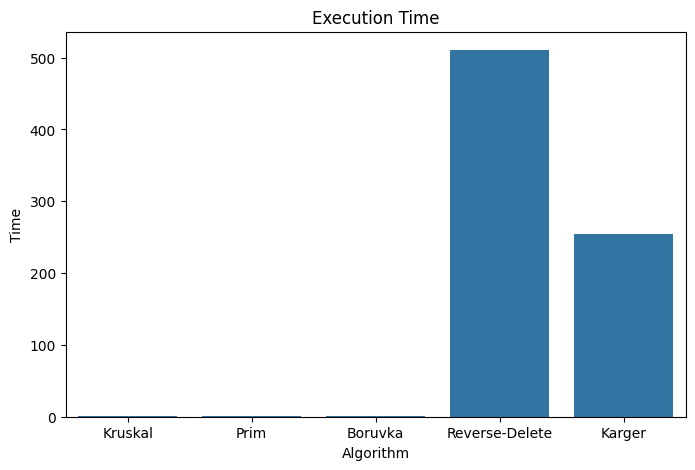

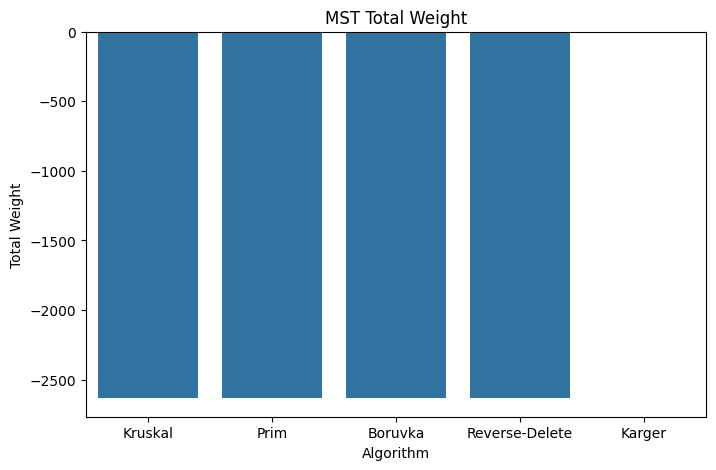

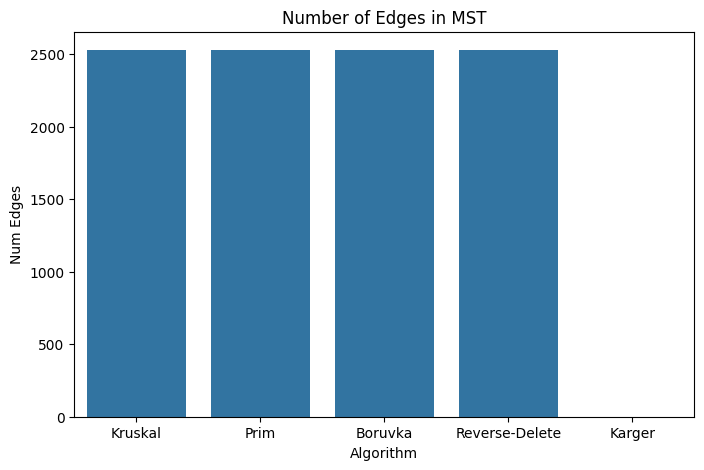

In [15]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Algorithm'})

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x = 'Algorithm', y = 'Time')
plt.title('Execution Time')
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x = 'Algorithm', y = 'Total Weight')
plt.title('MST Total Weight')
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x = 'Algorithm', y = 'Num Edges')
plt.title('Number of Edges in MST')
plt.show()

In [27]:
def animate_mst(original_graph, mst_graph, title="MST Animation", save_path=None):

    fig, ax = plt.subplots(figsize=(10, 7))
    pos = nx.spring_layout(original_graph, seed=42)

    edges = list(mst_graph.edges(data=True))
    frames = []
    temp_graph = nx.Graph()
    temp_graph.add_nodes_from(mst_graph.nodes())

    connected_nodes = set()
    step = 15
    next_threshold = step

    for u, v, data in edges:
        temp_graph.add_edge(u, v, **data)
        connected_nodes.update([u, v])

        if len(connected_nodes) >= next_threshold:
            frames.append(list(temp_graph.edges(data=True)))
            next_threshold += step

    if not frames or frames[-1] != list(temp_graph.edges(data=True)):
        frames.append(list(temp_graph.edges(data=True)))  # Add final frame if needed

    def update(frame_index):
        ax.clear()
        ax.set_title(title + " - Frame " + str(frame_index + 1) + " / " + str(len(frames)))
        frame_edges = frames[frame_index]
        nx.draw_networkx_nodes(mst_graph, pos, ax=ax, node_size=20)
        nx.draw_networkx_edges(mst_graph, pos, ax=ax, edgelist=frame_edges, edge_color='green', width=2)

    ani = FuncAnimation(fig, update, frames=len(frames), interval=300, repeat=False)

    if save_path:
        ani.save(save_path, writer='pillow')
    plt.close(fig)
    return ani

In [28]:
def save_mst_animation(graphs_dict, original_graph):

    for name, mst in graphs_dict.items():
        if name != "Karger":
            filename = name.lower() + "_mst_animation.gif"
            print("Saving animation for", name)
            animate_mst(original_graph, mst, title=name + " MST", save_path=filename)

In [29]:
def draw_sampled_msts(graphs_dict, original_graph):
    pos = nx.spring_layout(original_graph, seed=42)

    for name, mst in graphs_dict.items():
        if name != "Karger":
            fig, ax = plt.subplots(figsize=(10, 6))
            weights = [d['weight'] for _, _, d in mst.edges(data=True)]

            edges = nx.draw_networkx_edges(mst, pos, ax=ax, edge_color = weights, edge_cmap = plt.cm.viridis, width=1.5)
            nx.draw_networkx_nodes(mst, pos, ax=ax, node_size=20)

            ax.set_title(name + " MST")

            sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
            sm.set_array(weights)
            fig.colorbar(sm, ax=ax, label="Edge Weight")

            plt.show()

In [30]:
save_mst_animation(mst_graphs, G)

Saving animation for Kruskal
Saving animation for Prim
Saving animation for Boruvka
Saving animation for Reverse-Delete


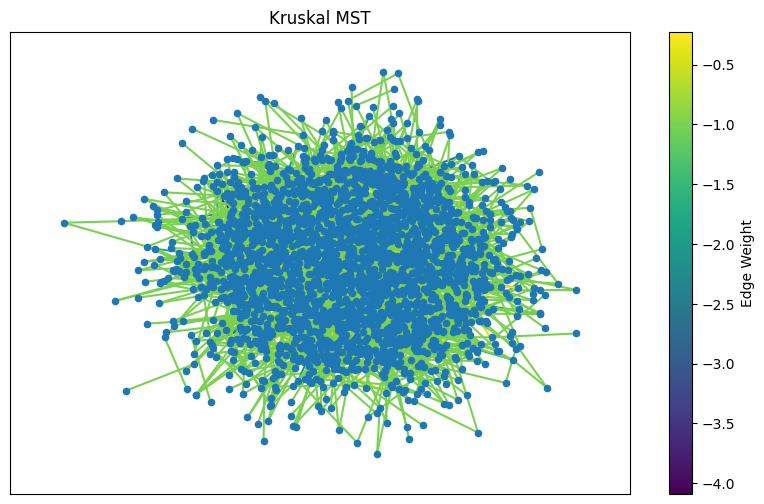

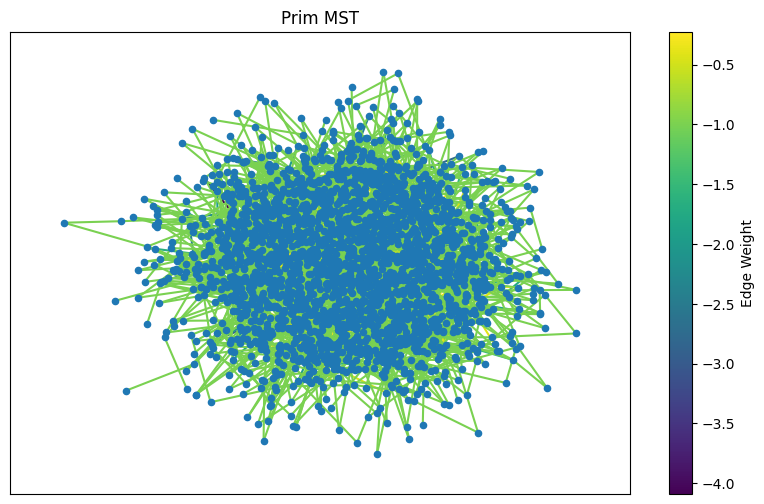

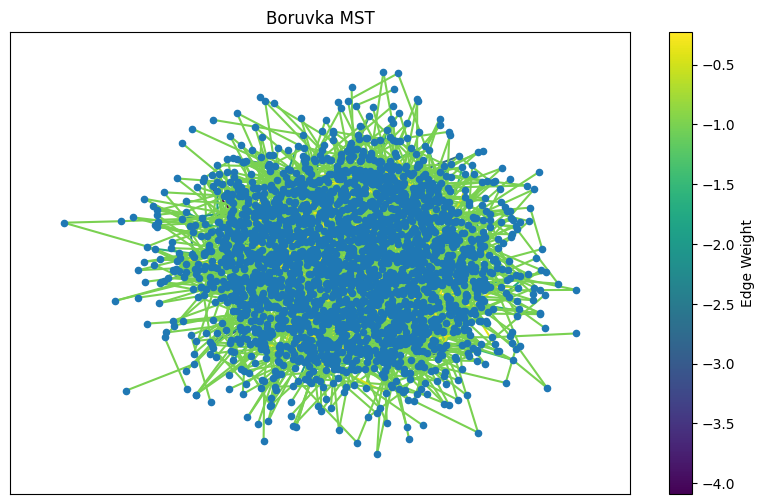

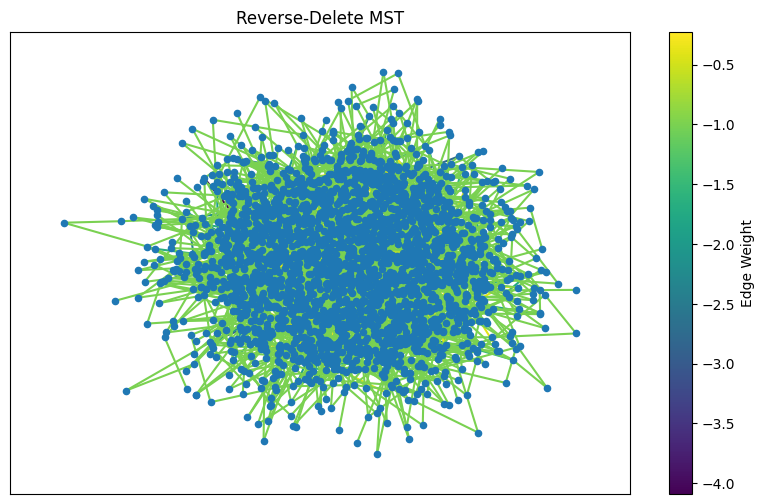

In [31]:
draw_sampled_msts(mst_graphs, G)

In [32]:
network_name = "econ-orani678"
node_count = G.number_of_nodes()
edge_count = G.number_of_edges()


growth_data = []

for algo_name in ["Kruskal", "Prim", "Boruvka", "Reverse-Delete"]:
    algo_result = results[algo_name]
    entry = {"Algorithm": algo_name, "Network": network_name, "Nodes": node_count, "Edges": edge_count, "Time": algo_result["Time"]}
    growth_data.append(entry)


growth_df = pd.DataFrame(growth_data)
growth_df.to_csv("mst_growth_data_econ_orani678.csv", index=False)
growth_df

,Algorithm,Network,Nodes,Edges,Time
0,Kruskal,econ-orani678,2529,86979,0.665307
1,Prim,econ-orani678,2529,86979,0.491758
2,Boruvka,econ-orani678,2529,86979,1.018921
3,Reverse-Delete,econ-orani678,2529,86979,510.515443
